## Objective:
- The objective from this project is to create a <b>Logistic Regression Classifier</b> to predict the <b>Stroke Condition</b>.
- <b>Stoke</b> is a condition in which either the blood flow to the brain stops or blood flow is excessive.

### Data:
- Data is provided in csv format in a file named <b>healthcare-dataset-stroke-data.csv</b>

### Column names and data types are as follow:
- id, integer.
- gender, string.
- age, double.
- hypertension, integer.
- heart_disease, integer.
- ever_married, string.
- work_type, string.
- Residence_type, string.
- avg_glucose_level, double.
- bmi, double.
- smoking_status, string.
- stroke, integer <b>(Target Label)</b>.
If the person has stroke the stroke label value is <b>"1"</b> otherwise <b>"0"</b>.

In [1]:
import findspark
findspark.init()
import pyspark

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder.getOrCreate()

### Creating a data schema programatically

In [4]:
from pyspark.sql.types import *

In [5]:
my_schema = StructType([StructField("id",IntegerType(), True),
                    StructField("gender", StringType(), True),
                    StructField("age", DoubleType(), True),
                    StructField("hypertension", IntegerType(), True),
                    StructField("heart_disease", IntegerType(), True),
                    StructField("ever_married", StringType(), True),
                    StructField("work_type", StringType(), True),
                    StructField("Residence_type", StringType(), True),
                    StructField("avg_glucose_level", DoubleType(), True),
                    StructField("bmi", DoubleType(), True),
                    StructField("smoking_status", StringType(), True),
                    StructField("stroke", IntegerType(), True)])

In [6]:
df = spark.read.csv('healthcare-dataset-stroke-data.csv',header=True, schema=my_schema)

In [7]:
df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [8]:
df.show(10)

+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
|   id|gender| age|hypertension|heart_disease|ever_married|    work_type|Residence_type|avg_glucose_level| bmi| smoking_status|stroke|
+-----+------+----+------------+-------------+------------+-------------+--------------+-----------------+----+---------------+------+
| 9046|  Male|67.0|           0|            1|         Yes|      Private|         Urban|           228.69|36.6|formerly smoked|     1|
|51676|Female|61.0|           0|            0|         Yes|Self-employed|         Rural|           202.21|null|   never smoked|     1|
|31112|  Male|80.0|           0|            1|         Yes|      Private|         Rural|           105.92|32.5|   never smoked|     1|
|60182|Female|49.0|           0|            0|         Yes|      Private|         Urban|           171.23|34.4|         smokes|     1|
| 1665|Female|79.0|           1|            0|         

In [9]:
from pyspark.sql.functions import *

In [10]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|201|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



In [11]:
import seaborn as sns

In [12]:
df_pandas = df.toPandas()

<AxesSubplot:xlabel='stroke', ylabel='count'>

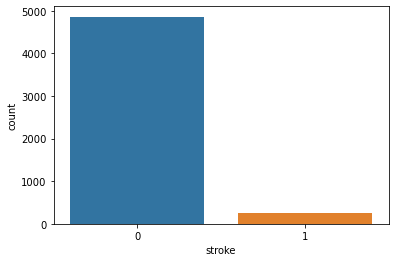

In [13]:
sns.countplot(x="stroke", data=df_pandas)

In [14]:
df.select(col("age")).describe().show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|              5110|
|   mean|43.226614481409015|
| stddev| 22.61264672311348|
|    min|              0.08|
|    max|              82.0|
+-------+------------------+



In [15]:
df_new = df.filter(df.age > 2) 

In [16]:
df_new.select("gender", "smoking_status").show()

+------+---------------+
|gender| smoking_status|
+------+---------------+
|  Male|formerly smoked|
|Female|   never smoked|
|  Male|   never smoked|
|Female|         smokes|
|Female|   never smoked|
|  Male|formerly smoked|
|  Male|   never smoked|
|Female|   never smoked|
|Female|        Unknown|
|Female|        Unknown|
|Female|   never smoked|
|Female|         smokes|
|Female|         smokes|
|  Male|        Unknown|
|Female|   never smoked|
|Female|   never smoked|
|  Male|         smokes|
|  Male|         smokes|
|Female|   never smoked|
|  Male|        Unknown|
+------+---------------+
only showing top 20 rows



In [17]:
df_new.select("gender").distinct().show()

+------+
|gender|
+------+
|Female|
| Other|
|  Male|
+------+



In [18]:
df_new.select("smoking_status").distinct().show()

+---------------+
| smoking_status|
+---------------+
|         smokes|
|        Unknown|
|   never smoked|
|formerly smoked|
+---------------+



In [19]:
df_new_2 = df_new.withColumn("gender", when(col("gender")=="Male", 1).otherwise(0))

In [20]:
df_new_3 = df_new_2.withColumn("smoking_status", when(col("smoking_status")=="never smoked", 0)
                                                .when(col("smoking_status")=="Unknown", 0.5)
                                                .when(col("smoking_status")=="formerly smoked", 0.75)
                                                .when(col("smoking_status")=="smokes", 1.0))

In [21]:
df_new_3.select("gender", "smoking_status").show()

+------+--------------+
|gender|smoking_status|
+------+--------------+
|     1|          0.75|
|     0|           0.0|
|     1|           0.0|
|     0|           1.0|
|     0|           0.0|
|     1|          0.75|
|     1|           0.0|
|     0|           0.0|
|     0|           0.5|
|     0|           0.5|
|     0|           0.0|
|     0|           1.0|
|     0|           1.0|
|     1|           0.5|
|     0|           0.0|
|     0|           0.0|
|     1|           1.0|
|     1|           1.0|
|     0|           0.0|
|     1|           0.5|
+------+--------------+
only showing top 20 rows



In [22]:
df_new_3.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: integer (nullable = false)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: double (nullable = true)
 |-- stroke: integer (nullable = true)



### Dealing with null value

In [23]:
from pyspark.ml.feature import Imputer
imputer = Imputer(inputCols= ["bmi"], outputCols = ["bmi"]).setStrategy("mean")
df_new_4 = imputer.fit(df_new_3).transform(df_new_3)

In [24]:
df_new_4.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df_new_4.columns]).show()

+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
| id|gender|age|hypertension|heart_disease|ever_married|work_type|Residence_type|avg_glucose_level|bmi|smoking_status|stroke|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+
|  0|     0|  0|           0|            0|           0|        0|             0|                0|  0|             0|     0|
+---+------+---+------------+-------------+------------+---------+--------------+-----------------+---+--------------+------+



### Splitting the data into training and test dataframes:
- 80% training and 20% test.
- seed = 42.

In [25]:
trainDF, testDF = df_new_4.randomSplit([.8,.2],seed=42)
print(f"There are {trainDF.count()} rows in the training set, and {testDF.count()} in the test set")

There are 3991 rows in the training set, and 944 in the test set


In [27]:
trainDF.write.parquet("train.parquet")

In [28]:
testDF.write.parquet("test.parquet")

In [29]:
trainDF = spark.read.parquet("train.parquet")

In [30]:
testDF = spark.read.parquet("test.parquet")

In [31]:
df_new_4.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: integer (nullable = false)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: double (nullable = true)
 |-- stroke: integer (nullable = true)



In [32]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

In [33]:
input_cols = ["ever_married", "work_type", "Residence_type"]
output_cols_idx = ["ever_married_idx", "work_type_idx", "Residence_type_idx"]
output_cols_ohe = ["ever_married_ohe", "work_type_ohe", "Residence_type_ohe"]

In [34]:
stringIndexer = StringIndexer(inputCols=input_cols, outputCols=output_cols_idx, handleInvalid='skip')

oheEncoder = OneHotEncoder(inputCols=output_cols_idx, outputCols=output_cols_ohe)

In [35]:
assemblerInputs = ["id", "gender", "age", "hypertension", "heart_disease",
                   "avg_glucose_level", "bmi", "smoking_status"] + output_cols_ohe

In [36]:
from pyspark.ml.feature import VectorAssembler

In [37]:
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol='features')

In [38]:
from pyspark.ml.classification import LogisticRegression

In [39]:
model = LogisticRegression(featuresCol="features", labelCol="stroke")

In [40]:
from pyspark.ml import Pipeline

In [41]:
pipeline = Pipeline(stages=[stringIndexer, oheEncoder, vecAssembler, model])

In [43]:
pipelineModel = pipeline.fit(trainDF)

In [44]:
predDF = pipelineModel.transform(testDF)

In [45]:
predDF.select("features").show()

+--------------------+
|            features|
+--------------------+
|(14,[0,1,2,5,6,8,...|
|(14,[0,2,5,6,9,13...|
|(14,[0,2,5,6,8,9]...|
|(14,[0,2,5,6,7,8,...|
|(14,[0,1,2,5,6,8,...|
|(14,[0,2,5,6,8,9]...|
|(14,[0,1,2,3,5,6,...|
|(14,[0,2,5,6,8,10...|
|(14,[0,2,5,6,7,12...|
|(14,[0,1,2,5,6,7,...|
|(14,[0,1,2,5,6,7,...|
|(14,[0,2,3,4,5,6,...|
|(14,[0,1,2,5,6,9]...|
|(14,[0,2,5,6,7,8,...|
|(14,[0,2,3,5,6,8,...|
|(14,[0,2,5,6,7,8,...|
|(14,[0,2,5,6,9,13...|
|[1473.0,1.0,69.0,...|
|[1666.0,1.0,70.0,...|
|(14,[0,2,5,6,9,13...|
+--------------------+
only showing top 20 rows



In [46]:
predDF.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: double (nullable = true)
 |-- stroke: integer (nullable = true)
 |-- ever_married_idx: double (nullable = false)
 |-- work_type_idx: double (nullable = false)
 |-- Residence_type_idx: double (nullable = false)
 |-- ever_married_ohe: vector (nullable = true)
 |-- work_type_ohe: vector (nullable = true)
 |-- Residence_type_ohe: vector (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [47]:
predDF.select("stroke", "prediction").show()

+------+----------+
|stroke|prediction|
+------+----------+
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     1|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     1|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
+------+----------+
only showing top 20 rows



In [48]:
predDF.select("stroke", "prediction").where(col("stroke") == 1).show()

+------+----------+
|stroke|prediction|
+------+----------+
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
|     1|       0.0|
+------+----------+
only showing top 20 rows



In [49]:
predDF.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  943|
|       1.0|    1|
+----------+-----+



In [50]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [51]:
evaluatorROC = BinaryClassificationEvaluator(rawPredictionCol='prediction'
                                             ,labelCol='stroke')

In [52]:
evaluatorROC.evaluate(predDF)

0.4994475138121547

### Improving Model Performance

In [101]:
df_balanced = df_new_4.withColumn("weightCol", when(col("stroke")==1, 0.96).otherwise(0.04))

In [102]:
df_balanced.select("stroke", "weightCol").show()

+------+---------+
|stroke|weightCol|
+------+---------+
|     1|     0.96|
|     1|     0.96|
|     1|     0.96|
|     1|     0.96|
|     1|     0.96|
|     1|     0.96|
|     1|     0.96|
|     1|     0.96|
|     1|     0.96|
|     1|     0.96|
|     1|     0.96|
|     1|     0.96|
|     1|     0.96|
|     1|     0.96|
|     1|     0.96|
|     1|     0.96|
|     1|     0.96|
|     1|     0.96|
|     1|     0.96|
|     1|     0.96|
+------+---------+
only showing top 20 rows



In [103]:
trainDF, testDF = df_balanced.randomSplit([.8,.2],seed=42)
print(f"There are {trainDF.count()} rows in the training set, and {testDF.count()} in the test set")

There are 3991 rows in the training set, and 944 in the test set


In [104]:
new_model = LogisticRegression(featuresCol="features", labelCol="stroke", weightCol="weightCol")

In [105]:
pipeline = Pipeline(stages=[stringIndexer, oheEncoder, vecAssembler, new_model])

In [106]:
pipelineModel = pipeline.fit(trainDF)

In [107]:
predDF = pipelineModel.transform(testDF)

In [108]:
predDF.select("stroke", "prediction").show()

+------+----------+
|stroke|prediction|
+------+----------+
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       0.0|
|     0|       1.0|
|     0|       0.0|
|     0|       1.0|
|     1|       1.0|
|     0|       0.0|
|     0|       1.0|
|     0|       0.0|
|     1|       1.0|
|     0|       0.0|
|     0|       1.0|
|     0|       1.0|
|     0|       1.0|
|     0|       0.0|
|     0|       1.0|
|     0|       1.0|
|     0|       0.0|
+------+----------+
only showing top 20 rows



In [109]:
predDF.select("stroke", "prediction").where(col("stroke") == 1).show()

+------+----------+
|stroke|prediction|
+------+----------+
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       0.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
|     1|       0.0|
|     1|       0.0|
|     1|       1.0|
|     1|       1.0|
|     1|       1.0|
+------+----------+
only showing top 20 rows



In [110]:
predDF.groupBy("prediction").count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0|  639|
|       1.0|  305|
+----------+-----+



In [111]:
evaluatorROC = BinaryClassificationEvaluator(rawPredictionCol='prediction'
                                             ,labelCol='stroke')

In [112]:
evaluatorROC.evaluate(predDF)

0.7594276809746423